## Reconstruction Error

In [28]:
NUM_SAMPLES = [10, 15, 20, 25]
SAMPLE_BUDGET_MULTIPLIERS = [3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
WORKLOADS = ["real-estate", "biodex"]
WORKLOAD_TO_LOGICAL_OP_IDS = {
    "real-estate": ["f069c376dc"],
    "biodex": ["9881bc62b0"],
}
NUM_TRIALS = 100

### Load Groundtruth Execution Data

In [29]:
import json
import numpy as np

workload_to_sentinel_plan_id = {
    "real-estate": (100, "4f754e3b01"),
    "biodex": (100, "9b3499f00a"),
}

# STORE MAPPING FROM NUMBER OF SAMPLES --> GROUNDTRUTH DATA
workload_to_raw_matrices = {workload: {} for workload in WORKLOADS}
for workload, tup in workload_to_sentinel_plan_id.items():
    if workload == "real-estate":
        continue

    n, plan_id = tup
    raw_matrices_fp = f"opt-profiling-data/raw-matrices-n-{n}-{plan_id}.json"
    with open(raw_matrices_fp, 'r') as f:
        # load mapping from logical_op_id --> (per-metric) matrices
        raw_matrices = json.load(f)

        # convert serialized matrices back into numpy arrays
        raw_matrices_arrays = {}
        for logical_op_id, matrices_dict in raw_matrices.items():
            if logical_op_id not in WORKLOAD_TO_LOGICAL_OP_IDS[workload]:
                continue

            metric_to_matrix = {}
            for metric, matrix in matrices_dict.items():
                # ignore selectivity for now
                if metric == "selectivity":
                    continue

                metric_to_matrix[metric] = np.array(matrix)

            raw_matrices_arrays[logical_op_id] = metric_to_matrix

        # store dictionary of arrays
        workload_to_raw_matrices[workload] = raw_matrices_arrays


### Adaptive Sampling Works?

In [171]:
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True) # no scientific notation

In [228]:
# compute errors from true col means and plot these errors as fcn. of rank and budget
col_exp_error_data = []
true_col_means = np.mean(val_matrix, axis=0)
for budget_frac in [0.1 * idx for idx in range(1, 10)]:
    for rank in [1, 2, 3, 4, 5, 6]:
        for idx in range(100):
            rs_col_means = rs_col_means_dict[budget_frac][rank][idx]
            mc_col_means = est_col_means_dict[budget_frac][rank][idx]
            rs_mean_pct_error = np.mean(np.abs(rs_col_means - true_col_means)/true_col_means)
            mc_mean_pct_error = np.mean(np.abs(mc_col_means - true_col_means)/true_col_means)
            rs_obs = {
                "budget_frac": budget_frac, "rank": rank, "mean_pct_error": rs_mean_pct_error, "label": "rs",
            }
            mc_obs = {
                "budget_frac": budget_frac, "rank": rank, "mean_pct_error": mc_mean_pct_error, "label": "mc",
            }
            col_exp_error_data.extend([rs_obs, mc_obs])

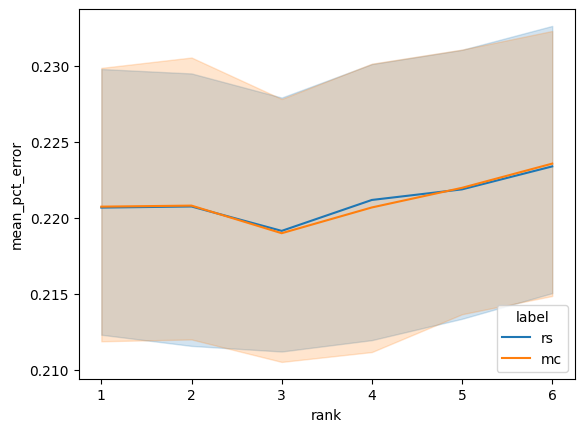

In [267]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sn

budget_frac = 0.5
fig1, ax = plt.subplots(1, 1)
df = pd.DataFrame(col_exp_error_data)
sub_df = df[((df.budget_frac - budget_frac) < 0.1) & ~(df.label.isin(['adapt']))]
sn.lineplot(sub_df, x="rank", y="mean_pct_error", hue="label", ax=ax)
g.yaxis.set_major_formatter(PercentFormatter(1))

In [236]:
# Try MC approach aimed at decreasing uncertainty
# for x = [10, 20, ..., 90], run 100 iterations of procedure:
# - compute sample mask with x% of matrix
# - compute column means using sample mask
# - complete matrix and compute column means w/completed matrix
def adaptive_complete_matrix(
    matrix: np.array,
    sample_budget: int,
    seed=42,
):  
    # ensure that each matrix has float dtype (not int)
    matrix = matrix.astype(float)

    # compute initial sample budget and perform sanity check
    num_rows, num_cols = matrix.shape
    init_sample_budget = 3*num_cols
    assert sample_budget >= init_sample_budget, "sample budget smaller than initial budget size!"

    # create initial sample mask
    sample_mask = create_sample_mask_from_budget(num_rows, num_cols, init_sample_budget, seed)

    # scale matrix columns
    obs_matrix = matrix.copy()
    col_means = np.mean(obs_matrix, axis=0, where=sample_mask.astype(bool))
    col_stds = np.std(obs_matrix, axis=0, where=sample_mask.astype(bool))

    # if we have some columns with 0 variance, set their true_col_stds entries equal to 1;
    # this will ensure that these entries are not scaled, but still have their mean translation
    zero_variance_cols = (col_stds == 0.0)
    col_stds[zero_variance_cols] = 1.0

    # create scaled version of observation matrix
    scaled_obs_matrix = (obs_matrix - col_means) / col_stds

    # compute k
    k = int(np.ceil((sample_budget - init_sample_budget) / 10))

    # iteratively: complete matrices, compute uncertainty, and pick next samples until sample budget is exhausted
    samples_drawn = init_sample_budget
    sample_budget_exhausted = False
    while not sample_budget_exhausted:
        # compute std of each column
        col_stds = np.std(obs_matrix, axis=0, where=sample_mask.astype(bool))
        zero_variance_cols = (col_stds == 0.0)
        col_stds[zero_variance_cols] = np.min(col_stds) # TODO: error?

        # compute number of samples to draw
        num_samples_to_draw = min(k, sample_budget - samples_drawn)

        if (col_stds == 0).all():
            # give all columns equal weight
            col_alloc_weights = np.ones(num_cols) / num_samples_to_draw
        else:
            # compute ratio of std relative to sum
            col_alloc_weights = col_stds / np.sum(col_stds)

        # allocate samples to columns based on weight
        idx = 0
        col_order = np.argsort(-col_alloc_weights)
        allocated_samples = np.zeros(num_cols)
        while np.sum(allocated_samples) < num_samples_to_draw:
            col = col_order[idx % num_cols]
            ideal_weight_allocation = int(np.ceil(col_alloc_weights[col] * num_samples_to_draw))
            samples_left_to_draw = num_samples_to_draw - np.sum(allocated_samples)
            samples_left_in_col = np.sum(sample_mask[:,col]==0) - allocated_samples[col]
            num_alloc_samples = min(ideal_weight_allocation, samples_left_to_draw, samples_left_in_col)
            allocated_samples[col] += num_alloc_samples
            idx += 1

        assert np.sum(allocated_samples) == num_samples_to_draw

        # for each column with non-zero weight, randomly sample a set of previously unobserved entries
        for col, sample_size in enumerate(allocated_samples):
            if int(sample_size) > 0:
                sampled_rows = rng.choice(np.where(sample_mask[:,col]==0)[0], size=int(sample_size), replace=False)
                sample_mask[sampled_rows, col] = 1

        if samples_drawn == sample_budget:
            sample_budget_exhausted = True
        else:
            samples_drawn += num_samples_to_draw

    # sanity check that matrix was properly sampled
    assert int(np.sum(sample_mask)) == int(sample_budget)

    # compute and return col estimates from final completed matrix
    return np.mean(obs_matrix, axis=0, where=sample_mask.astype(bool)), sample_mask


adapt_col_means_dict = {
    budget_frac: {rank: [] for rank in [1,2,3,4,5,6]}
    for budget_frac in [0.1 * idx for idx in range(1, 10)]
}
adapt_sample_masks_dict = {
    budget_frac: {rank: [] for rank in [1,2,3,4,5,6]}
    for budget_frac in [0.1 * idx for idx in range(1, 10)]
}

num_rows, num_cols = val_matrix.shape
for budget_frac in [0.1 * idx for idx in range(5, 10)]:
    for rank in [1, 2, 3, 4, 5, 6]:
        print(f"{budget_frac} -- {rank}")
        # run trials
        outputs = None
        with ProcessPoolExecutor(max_workers=35) as executor:
            start_time = time.time()
            futures = [
                executor.submit(
                    adaptive_complete_matrix,
                    val_matrix,
                    budget_frac * num_rows * num_cols,
                    abs(hash(f"{budget_frac}-{trial_idx}-{rank}"))
                )
                for trial_idx in range(100)
            ]
            done_futures, not_done_futures = [], futures
            while len(not_done_futures) > 0:
                prev_done_futures = len(done_futures)
                done_futures, not_done_futures = wait(futures, timeout=1.0)
                if len(done_futures) > prev_done_futures:
                    print(f"Finished {len(done_futures)} at time {time.time()-start_time:.3f}")
            outputs = [future.result() for future in done_futures]

        for adapt_est_col_mean, sample_mask in outputs:
            adapt_col_means_dict[budget_frac][rank].append(adapt_est_col_mean)
            adapt_sample_masks_dict[budget_frac][rank].append(sample_mask)


0.5 -- 1
Finished 100 at time 0.287
0.5 -- 2
Finished 100 at time 0.301
0.5 -- 3
Finished 100 at time 0.298
0.5 -- 4
Finished 100 at time 0.292
0.5 -- 5
Finished 100 at time 0.316
0.5 -- 6
Finished 100 at time 0.274
0.6000000000000001 -- 1
Finished 100 at time 0.275
0.6000000000000001 -- 2
Finished 100 at time 0.281
0.6000000000000001 -- 3
Finished 100 at time 0.294
0.6000000000000001 -- 4
Finished 100 at time 0.316
0.6000000000000001 -- 5
Finished 100 at time 0.288
0.6000000000000001 -- 6
Finished 100 at time 0.274
0.7000000000000001 -- 1
Finished 100 at time 0.284
0.7000000000000001 -- 2
Finished 100 at time 0.277
0.7000000000000001 -- 3
Finished 100 at time 0.282
0.7000000000000001 -- 4
Finished 100 at time 0.299
0.7000000000000001 -- 5
Finished 100 at time 0.290
0.7000000000000001 -- 6
Finished 100 at time 0.295
0.8 -- 1
Finished 100 at time 0.302
0.8 -- 2
Finished 100 at time 0.309
0.8 -- 3
Finished 100 at time 0.321
0.8 -- 4
Finished 100 at time 0.278
0.8 -- 5
Finished 100 at tim

In [243]:
budget_frac = 0.5
rank = 1
trial_idx = 0
true_col_means = np.mean(val_matrix, axis=0)
sample_mask = adapt_sample_masks_dict[budget_frac][rank][trial_idx]
print(sample_mask)
print(np.sum(sample_mask))
col_means = np.mean(val_matrix, axis=0, where=sample_mask.astype(bool))
mean_pct_error = np.mean(abs(col_means - true_col_means)/true_col_means)
print(col_means)
print(mean_pct_error)

[[0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1.]
 [0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0.]
 [1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1.]
 [1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0.]]
80.0
[ 5.49301  4.04832  4.39527  2.65009  3.23406  2.68064  4.36726  3.14962
  2.02052  3.24103 18.46553  3.78708  3.42892  3.40298  4.453    0.66469]
0.12721802560374826


In [244]:
budget_frac = 0.5
rank = 1
trial_idx = 1
true_col_means = np.mean(val_matrix, axis=0)
sample_mask = adapt_sample_masks_dict[budget_frac][rank][trial_idx]
print(sample_mask)
print(np.sum(sample_mask))
col_means = np.mean(val_matrix, axis=0, where=sample_mask.astype(bool))
mean_pct_error = np.mean(abs(col_means - true_col_means)/true_col_means)
print(col_means)
print(mean_pct_error)

[[1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.]
 [0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.]
 [1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1.]]
80.0
[ 5.08739  4.84385  5.68698  3.0067   3.46463  3.12766  4.47347  3.07741
  1.97185  3.23943 18.46553  3.09081  4.46078  2.67327  4.60209 15.87503]
0.09537732128255987


In [229]:
# compute errors from true col means and plot these errors as fcn. of rank and budget
true_col_means = np.mean(val_matrix, axis=0)
for budget_frac in [0.1 * idx for idx in range(5, 10)]:
    for rank in [1, 2, 3, 4, 5, 6]:
        for idx in range(100):
            adapt_col_means = adapt_col_means_dict[budget_frac][rank][idx]
            adapt_mean_pct_error = np.mean(np.abs(adapt_col_means - true_col_means)/true_col_means)
            adapt_obs = {
                "budget_frac": budget_frac, "rank": rank, "mean_pct_error": adapt_mean_pct_error, "label": "adapt",
            }
            col_exp_error_data.extend([adapt_obs])

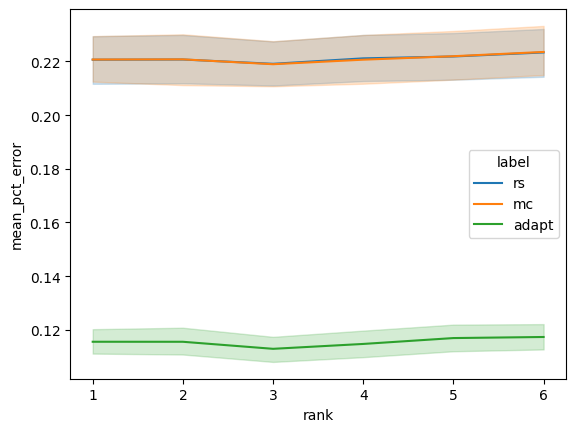

In [235]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sn

budget_frac = 0.5
fig1, ax = plt.subplots(1, 1)
df = pd.DataFrame(col_exp_error_data)
sub_df = df[(df.budget_frac - budget_frac) < 0.1]
sn.lineplot(sub_df, x="rank", y="mean_pct_error", hue="label", ax=ax)
g.yaxis.set_major_formatter(PercentFormatter(1))

### Define Helpers

### Run Trial Logic

In [48]:
from palimpzest.utils.matrix_completion_helpers import (
    adaptive_stratified_sampling,
    adaptive_mab_sampling,
)

def run_trial(n, sample_budget, raw_matrices, trial_idx):
    # compute seed for all rngs
    seed = np.abs(hash(f"abc{n}-{sample_budget}-{trial_idx}"))

    # get the dimensions of the raw matrix
    raw_num_rows, raw_num_cols = raw_matrices["cost"].shape

    # randomly subsample n rows from the raw matrix to treat as a validation set
    rng = np.random.default_rng(seed=seed)
    val_row_indices = np.sort(rng.choice(np.arange(raw_num_rows), size=n, replace=False))

    # construct validation matrices based on validation sample
    val_matrices = {metric: raw_matrix[val_row_indices, :].copy() for metric, raw_matrix in raw_matrices.items()}

    # -- create mask for lower bound --
    lower_bound_sample_mask = np.zeros((raw_num_rows, raw_num_cols))
    lower_bound_sample_mask[val_row_indices, :] = 1

    # NOTE: currently only computing stratified sampling lower bound for time
    # -- create mask for stratified sampling lower bound --
    stratified_lower_bound_sample_mask = np.zeros((raw_num_rows, raw_num_cols))
    full_sample_row_indices = rng.choice(val_row_indices, size=3, replace=False)
    stratified_lower_bound_sample_mask[full_sample_row_indices, :] = 1

    col_stds = np.std(val_matrices['time'], axis=0)
    col_alloc_weights = col_stds/np.sum(col_stds)
    num_samples_to_draw = sample_budget - 3 * raw_num_cols
    if num_samples_to_draw > 0:
        # allocate samples to columns based on weight
        col_order = np.argsort(-col_alloc_weights)
        allocated_samples = np.zeros(raw_num_cols)
        for col in col_order:
            ideal_weight_allocation = int(np.ceil(col_alloc_weights[col] * num_samples_to_draw))
            samples_left_to_draw = num_samples_to_draw - np.sum(allocated_samples)
            samples_left_in_col = np.sum(stratified_lower_bound_sample_mask[:,col]==0) - allocated_samples[col]
            num_alloc_samples = min(ideal_weight_allocation, samples_left_to_draw, samples_left_in_col)
            allocated_samples[col] += num_alloc_samples
            
            if np.sum(allocated_samples) == num_samples_to_draw:
                break
    
        # if we still have samples left-over, allocate them one-at-time to columns w/fewest samples --> most
        while np.sum(allocated_samples) < num_samples_to_draw:
            col_order = np.argsort(np.sum(stratified_lower_bound_sample_mask, axis=0))
            for col in col_order:
                allocated_samples[col] += 1
                if np.sum(allocated_samples) == num_samples_to_draw:
                    break
    
        # for each column with non-zero weight, randomly sample a set of previously unobserved entries
        for col, sample_size in enumerate(allocated_samples):
            if int(sample_size) > 0:
                sampled_rows = rng.choice(np.where(stratified_lower_bound_sample_mask[:,col]==0)[0], size=int(sample_size), replace=False)
                stratified_lower_bound_sample_mask[sampled_rows, col] = 1

    # -- create masks for random sampling --
    # from these rows, randomly subsample fully sampled rows
    random_fixed_row_indices = rng.choice(val_row_indices, size=int(sample_budget / raw_num_cols), replace=False)
    random_fixed_row_sample_mask = np.zeros((raw_num_rows, raw_num_cols))
    random_fixed_row_sample_mask[random_fixed_row_indices, :] = 1

    # as a separate evaluation, fully sample 1 row, and then randomly sample the remaining r*m
    random_full_row_index = rng.choice(val_row_indices, size=1)
    random_any_entry_sample_mask = np.zeros((raw_num_rows, raw_num_cols))
    random_any_entry_sample_mask[random_full_row_index, :] = 1
    potential_entries = np.array([
        (row, col)
        for row in val_row_indices
        for col in np.arange(raw_num_cols)
        if row not in random_full_row_index
    ])
    # sampled_entries = rng.choice(potential_entries, size=rank*raw_num_cols, replace=False)
    sampled_entries = rng.choice(potential_entries, size=sample_budget - raw_num_cols, replace=False)
    for row, col in sampled_entries:
        random_any_entry_sample_mask[row, col] = 1

    # run our adaptive MAB and stratified sampling algorithms
    num_rows, num_cols = val_matrices["cost"].shape
    abacus_mab_sample_mask = adaptive_mab_sampling(
        val_matrices,
        num_rows,
        num_cols,
        sample_budget,
        p_distr={"cost": 0, "time": 1, "quality": 0},
        seed=seed,
    )
    abacus_stratified_sample_mask = adaptive_stratified_sampling(
        val_matrices,
        num_rows,
        num_cols,
        sample_budget,
        p_distr={"cost": 0, "time": 1, "quality": 0},
        seed=seed,
    )
    # abacus_stratified_sample_mask = np.zeros((len(val_row_indices), raw_num_cols))

    # reconstruct abacus sample mask(s) on full matrix; val_row_indices contains the indices of the rows
    # in the full matrix; their position (idx) in val_row_indices is the index of the row in abacus sample mask(s)
    full_abacus_mab_sample_mask = np.zeros((raw_num_rows, raw_num_cols))
    full_abacus_stratified_sample_mask = np.zeros((raw_num_rows, raw_num_cols))
    for idx, val_row_idx in enumerate(val_row_indices):
        full_abacus_mab_sample_mask[val_row_idx, :] = abacus_mab_sample_mask[idx, :]
        full_abacus_stratified_sample_mask[val_row_idx, :] = abacus_stratified_sample_mask[idx, :]

    return (
        full_abacus_mab_sample_mask,
        full_abacus_stratified_sample_mask,
        lower_bound_sample_mask,
        stratified_lower_bound_sample_mask,
        random_fixed_row_sample_mask,
        random_any_entry_sample_mask,
    )


## Run Experiments

In [49]:
# setup output data structures
def create_empty_output_dict():
    return {
        workload: {
            # n: {rank: {logical_op_id: [] for logical_op_id in WORKLOAD_TO_LOGICAL_OP_IDS[workload]} for rank in RANKS}
            n: {mult: {logical_op_id: [] for logical_op_id in WORKLOAD_TO_LOGICAL_OP_IDS[workload]} for mult in SAMPLE_BUDGET_MULTIPLIERS}
            for n in NUM_SAMPLES
        }
        for workload in WORKLOADS
    }

abacus_mab_sample_masks = create_empty_output_dict()
abacus_mab_sample_masks_copy = create_empty_output_dict()
abacus_stratified_sample_masks = create_empty_output_dict()
abacus_stratified_sample_masks_copy = create_empty_output_dict()
lower_bound_sample_masks = create_empty_output_dict()
lower_bound_sample_masks_copy = create_empty_output_dict()
stratified_lower_bound_sample_masks = create_empty_output_dict()
stratified_lower_bound_sample_masks_copy = create_empty_output_dict()
random_fixed_row_sample_masks = create_empty_output_dict()
random_fixed_row_sample_masks_copy = create_empty_output_dict()
random_any_entry_sample_masks = create_empty_output_dict()
random_any_entry_sample_masks_copy = create_empty_output_dict()

In [50]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, wait
import os
import time
from tqdm import tqdm
os.makedirs("cached-matrices", exist_ok=True)

# generate a bunch of data from many matrix completions
for workload in WORKLOADS:
    if workload == "real-estate":
        continue
    for n in tqdm(NUM_SAMPLES, position=0, leave=True):
        for multiplier in tqdm(SAMPLE_BUDGET_MULTIPLIERS, position=1, leave=True):
            for logical_op_id in WORKLOAD_TO_LOGICAL_OP_IDS[workload]:
                # get the groundtruth mapping from metric --> execution_data
                raw_matrices = workload_to_raw_matrices[workload][logical_op_id]

                # minimum sample budget is number of columns in matrix; we then multiply this minima
                # by increasingly large multipliers
                # sample_budget = (rank + 1) * raw_matrices["cost"].shape[1]
                sample_budget = int(np.floor(multiplier * raw_matrices["cost"].shape[1]))

                # # run NUM_TRIALS trials
                # outputs = None
                # with ProcessPoolExecutor(max_workers=35) as executor:
                #     start_time = time.time()
                #     futures = [
                #         executor.submit(run_trial, n, sample_budget, raw_matrices, trial_idx)
                #         for trial_idx in range(NUM_TRIALS)
                #     ]
                #     done_futures, not_done_futures = [], futures
                #     while len(not_done_futures) > 0:
                #         prev_done_futures = len(done_futures)
                #         done_futures, not_done_futures = wait(futures, timeout=1.0)
                #         if len(done_futures) > prev_done_futures:
                #             print(f"Finished {len(done_futures)} at time {time.time()-start_time:.3f}")

                #     outputs = [future.result() for future in done_futures]
                # for output in outputs:
                for trial_idx in tqdm(range(NUM_TRIALS), position=2, leave=True):
                    output = run_trial(n, sample_budget, raw_matrices, trial_idx)
                    abacus_mab_sample_mask, abacus_stratified_sample_mask = output[0], output[1]
                    lower_bound_sample_mask, stratified_lower_bound_sample_mask = output[2], output[3]
                    random_fixed_row_sample_mask, random_any_entry_sample_mask = output[4], output[5]

                    abacus_mab_sample_masks[workload][n][multiplier][logical_op_id].append(abacus_mab_sample_mask)
                    abacus_mab_sample_masks_copy[workload][n][multiplier][logical_op_id].append(abacus_mab_sample_mask.tolist())

                    abacus_stratified_sample_masks[workload][n][multiplier][logical_op_id].append(abacus_stratified_sample_mask)
                    abacus_stratified_sample_masks_copy[workload][n][multiplier][logical_op_id].append(abacus_stratified_sample_mask.tolist())

                    lower_bound_sample_masks[workload][n][multiplier][logical_op_id].append(lower_bound_sample_mask)
                    lower_bound_sample_masks_copy[workload][n][multiplier][logical_op_id].append(lower_bound_sample_mask.tolist())

                    stratified_lower_bound_sample_masks[workload][n][multiplier][logical_op_id].append(stratified_lower_bound_sample_mask)
                    stratified_lower_bound_sample_masks_copy[workload][n][multiplier][logical_op_id].append(stratified_lower_bound_sample_mask.tolist())

                    random_fixed_row_sample_masks[workload][n][multiplier][logical_op_id].append(random_fixed_row_sample_mask)
                    random_fixed_row_sample_masks_copy[workload][n][multiplier][logical_op_id].append(random_fixed_row_sample_mask.tolist())

                    random_any_entry_sample_masks[workload][n][multiplier][logical_op_id].append(random_any_entry_sample_mask)
                    random_any_entry_sample_masks_copy[workload][n][multiplier][logical_op_id].append(random_any_entry_sample_mask.tolist())

    exp_str = "-adaptive-sample"

    with open(f"cached-matrices/{workload}-cached-abacus-mab-sample-masks{exp_str}.json", "w") as f:
        json.dump(abacus_mab_sample_masks_copy[workload], f)

    with open(f"cached-matrices/{workload}-cached-abacus-stratified-sample-masks{exp_str}.json", "w") as f:
        json.dump(abacus_stratified_sample_masks_copy[workload], f)

    with open(f"cached-matrices/{workload}-cached-lower-bound-sample-masks{exp_str}.json", "w") as f:
        json.dump(lower_bound_sample_masks_copy[workload], f)

    with open(f"cached-matrices/{workload}-cached-stratified-lower-bound-sample-masks{exp_str}.json", "w") as f:
        json.dump(stratified_lower_bound_sample_mask[workload], f)

    with open(f"cached-matrices/{workload}-cached-random-fixed-row-sample-masks{exp_str}.json", "w") as f:
        json.dump(random_fixed_row_sample_masks_copy[workload], f)

    with open(f"cached-matrices/{workload}-cached-random-any-entry-sample-masks{exp_str}.json", "w") as f:
        json.dump(random_any_entry_sample_masks_copy[workload], f)

  0%|                                                                                                                                      | 0/6 [00:00<?, ?it/s]

  0%|                                                                                                                                    | 0/100 [00:00<?, ?it/s]

 31%|█████████████████████████████████████▊                                                                                    | 31/100 [00:00<00:00, 309.37it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 365.41it/s]

 17%|█████████████████████                                                                                                         | 1/6 [00:00<00:01,  3.58it/s]

  0%|                                                                                                                                    | 0/100 [00:00<?, ?it/s]

  3%|███▋             

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [51]:
import scipy.stats as stats

error_data = []
for workload in WORKLOADS:
    if workload == "real-estate":
        continue
    for n in NUM_SAMPLES:
        for multiplier in SAMPLE_BUDGET_MULTIPLIERS:
            for logical_op_id in WORKLOAD_TO_LOGICAL_OP_IDS[workload]:
                # get the groundtruth matrix data
                raw_matrices = workload_to_raw_matrices[workload][logical_op_id]

                for trial_idx in range(NUM_TRIALS):
                    # get the sample masks for this trial
                    random_fixed_row_sample_mask = random_fixed_row_sample_masks[workload][n][multiplier][logical_op_id][trial_idx]
                    random_any_entry_sample_mask = random_any_entry_sample_masks[workload][n][multiplier][logical_op_id][trial_idx]
                    lower_bound_sample_mask = lower_bound_sample_masks[workload][n][multiplier][logical_op_id][trial_idx]
                    stratified_lower_bound_sample_mask = stratified_lower_bound_sample_masks[workload][n][multiplier][logical_op_id][trial_idx]
                    abacus_mab_sample_mask = abacus_mab_sample_masks[workload][n][multiplier][logical_op_id][trial_idx]
                    abacus_stratified_sample_mask = abacus_stratified_sample_masks[workload][n][multiplier][logical_op_id][trial_idx]

                    # compute mean percent error of estimations
                    rng = np.random.default_rng(seed=np.abs(hash(f"{n}-{sample_budget}-{trial_idx}")))
                    for metric in ["cost", "time", "quality"]:
                        # groundtruth matrix
                        raw_matrix = raw_matrices[metric]
                        sample_budget = int(np.floor(multiplier * raw_matrix.shape[1]))

                        # compute groundtruth estimates of (per-operator) metric
                        true_col_means = np.mean(raw_matrix, axis=0)

                        # compute lower bound estimates of (per-operator) metric
                        lower_bound_col_means = np.mean(raw_matrix, axis=0, where=lower_bound_sample_mask.astype(bool))
                        stratified_lower_bound_col_means = np.mean(raw_matrix, axis=0, where=stratified_lower_bound_sample_mask.astype(bool))

                        # compute abacus reconstructed estimates of (per-operator) metric
                        abacus_mab_est_col_means = np.mean(raw_matrix, axis=0, where=abacus_mab_sample_mask.astype(bool))
                        abacus_stratified_est_col_means = np.mean(raw_matrix, axis=0, where=abacus_stratified_sample_mask.astype(bool))

                        # compute random sample estimates of (per-operator) metric where we use the fixed row mask
                        est_random_fixed_row_mask_means = np.mean(raw_matrix, axis=0, where=random_fixed_row_sample_mask.astype(bool))

                        # compute random sample estimates of (per-operator) metric where we use the any entry mask
                        est_random_any_entry_mask_means = np.mean(raw_matrix, axis=0, where=random_any_entry_sample_mask.astype(bool))

                        # compute error from mean divided by size of mean
                        lower_bound_mean_pct_error = np.mean(np.abs(lower_bound_col_means - true_col_means)/true_col_means)
                        stratified_lower_bound_mean_pct_error = np.mean(np.abs(stratified_lower_bound_col_means - true_col_means)/true_col_means)
                        abacus_mab_mean_pct_error = np.mean(np.abs(abacus_mab_est_col_means - true_col_means)/true_col_means)
                        abacus_stratified_mean_pct_error = np.mean(np.abs(abacus_stratified_est_col_means - true_col_means)/true_col_means)
                        random_fixed_row_mask_mean_pct_error = np.mean(np.abs(est_random_fixed_row_mask_means - true_col_means)/true_col_means)
                        random_any_entry_mask_mean_pct_error = np.mean(np.abs(est_random_any_entry_mask_means - true_col_means)/true_col_means)

                        # construct one record for our estimate and one record for the random sampling estimate
                        lower_bound_obs = {
                            "workload": workload, "val_samples": n, "sample_budget": sample_budget, "logical_op_id": logical_op_id,
                            "metric": metric, "trial_idx": trial_idx, "label": "lower-bound", "mean_pct_error": lower_bound_mean_pct_error,
                        }
                        stratified_lower_bound_obs = {
                            "workload": workload, "val_samples": n, "sample_budget": sample_budget, "logical_op_id": logical_op_id,
                            "metric": metric, "trial_idx": trial_idx, "label": "strfd-lower-bound", "mean_pct_error": stratified_lower_bound_mean_pct_error,
                        }
                        abacus_mab_obs = {
                            "workload": workload, "val_samples": n, "sample_budget": sample_budget, "logical_op_id": logical_op_id,
                            "metric": metric, "trial_idx": trial_idx, "label": "abacus-mab", "mean_pct_error": abacus_mab_mean_pct_error,
                        }
                        abacus_stratified_obs = {
                            "workload": workload, "val_samples": n, "sample_budget": sample_budget, "logical_op_id": logical_op_id,
                            "metric": metric, "trial_idx": trial_idx, "label": "abacus-std", "mean_pct_error": abacus_stratified_mean_pct_error,
                        }
                        random_fixed_obs = {
                            "workload": workload, "val_samples": n, "sample_budget": sample_budget, "logical_op_id": logical_op_id,
                            "metric": metric, "trial_idx": trial_idx, "label": "fixed-random", "mean_pct_error": random_fixed_row_mask_mean_pct_error,
                        }
                        random_any_obs = {
                            "workload": workload, "val_samples": n, "sample_budget": sample_budget, "logical_op_id": logical_op_id,
                            "metric": metric, "trial_idx": trial_idx, "label": "any-random", "mean_pct_error": random_any_entry_mask_mean_pct_error,
                        }
                        error_data.extend([lower_bound_obs, stratified_lower_bound_obs, abacus_mab_obs, abacus_stratified_obs, random_fixed_obs, random_any_obs])


In [52]:
import pandas as pd

error_df = pd.DataFrame(error_data)

In [53]:
exp_str = "-adaptive-sample"
error_df.to_csv(f"opt-results/biodex_error_data_100_trials_new_exp{exp_str}.csv", index=False)

In [54]:
error_df[error_df.metric=="quality"].groupby("label").mean("mean_pct_error")

,val_samples,sample_budget,trial_idx,mean_pct_error
label,,,,
abacus-mab,17.5,88.0,49.5,0.352066
abacus-std,17.5,88.0,49.5,0.376988
any-random,17.5,88.0,49.5,0.363744
fixed-random,17.5,88.0,49.5,0.344906
lower-bound,17.5,88.0,49.5,0.176848
strfd-lower-bound,17.5,88.0,49.5,0.376064


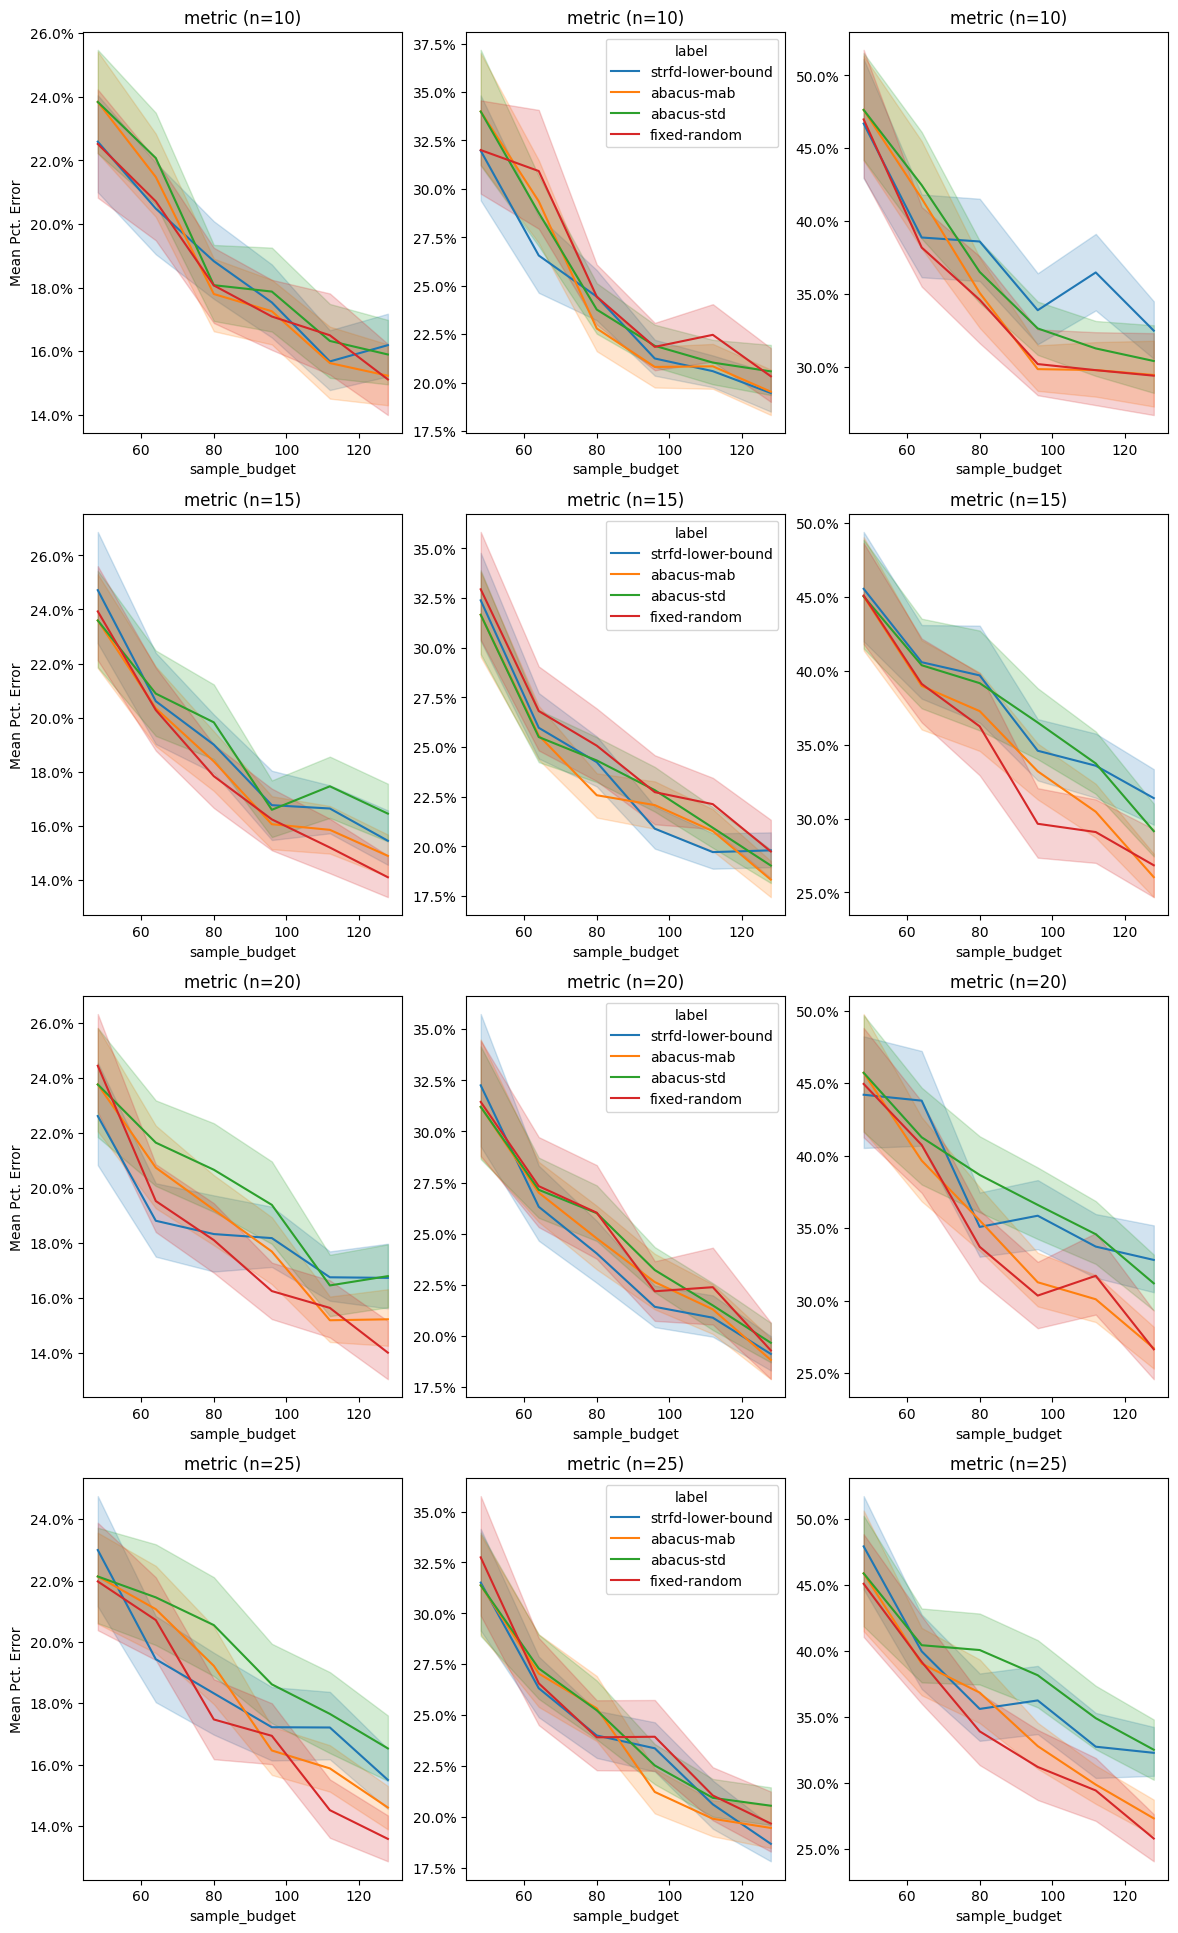

In [58]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sn

workload = "biodex"
fig1, axs = plt.subplots(4, 3, figsize=(14, 24))
for row_idx, n in enumerate([10, 15, 20, 25]):
    for col_idx, metric in enumerate(["cost", "time", "quality"]):
        results_df = error_df[(error_df.val_samples == n) & (error_df.workload == "biodex") & (error_df.metric == metric)]
        results_df = results_df[~results_df.label.isin(['any-random','lower-bound'])]
        g = sn.lineplot(results_df, x="sample_budget", y="mean_pct_error", hue="label", ax=axs[row_idx][col_idx])
        g.set_title(f"metric (n={n})") #TODO
        g.yaxis.set_major_formatter(PercentFormatter(1))
        # g.xaxis.set_major_formatter(PercentFormatter(1))
        if col_idx == 0:
            g.set_ylabel("Mean Pct. Error")
        else:
            g.set_ylabel(None)
        if col_idx != 1:
            g.legend_.remove()
    # axs.title(f"Operator Mean Pct. Error (n={n})")
fig1.savefig(f"opt-results/{workload}-error-num-samples-all{exp_str}.png")

In [60]:
# 4, 10, 15
np.mean(raw_matrices['quality'], axis=0)

array([0.42975768, 0.49435023, 0.48179268, 0.32339965, 0.31799101,
       0.45565181, 0.27069048, 0.49738539, 0.24988999, 0.29812864,
       0.23914142, 0.49091759, 0.31884888, 0.2266746 , 0.33320501,
       0.29479475])

In [25]:
workload = "biodex"
n = 10
multiplier = 5
logical_op_id = "9881bc62b0"
trial_idx = 0
np.sum(abacus_mab_sample_masks[workload][n][multiplier][logical_op_id][trial_idx], axis=0)

array([3., 6., 5., 5., 6., 5., 3., 6., 5., 4., 7., 3., 4., 5., 4., 9.])

In [26]:
agg = np.zeros(16)
for trial_idx in range(100):
    agg += np.sum(abacus_mab_sample_masks[workload][n][multiplier][logical_op_id][trial_idx], axis=0)
print(agg / 100)

[4.31 3.89 3.92 4.86 8.24 3.73 3.98 4.52 4.19 4.08 7.91 4.47 5.06 4.44
 4.91 7.49]


In [27]:
agg = np.zeros(16)
for trial_idx in range(100):
    agg += np.sum(abacus_stratified_sample_masks[workload][n][multiplier][logical_op_id][trial_idx], axis=0)
print(agg / 100)

[4.86 3.83 4.46 3.72 8.27 3.61 3.71 4.69 3.07 3.62 9.42 4.82 4.89 4.4
 4.74 7.89]


In [ ]:
fig, ax = plt.subplots()
trial_idx = 0
metric = 'time'
losses = all_losses[trial_idx][metric]
recon_losses = all_recon_losses[trial_idx][metric]
col_losses = all_col_losses[trial_idx][metric]

ax.plot([idx for idx in range(len(losses))], losses, label="loss")
ax.plot([idx for idx in range(len(recon_losses))], recon_losses, label="recon_loss")
ax.plot([idx for idx in range(len(col_losses))], col_losses, label="col_loss")
ax.set_ylabel("loss")
ax.set_xlabel("epoch")
ax.legend()
plt.show()

## Exploration

In [223]:
np.set_printoptions(precision=5, linewidth=250)

In [29]:
def run_trial_with_losses(rank, raw_matrices_dict, trial_idx):
    # only use single torch thread
    torch.set_num_threads(2)

    # create a sample matrix; every raw matrix will have the same shape for a given logical_op_id;
    # we use the "cost" matrix to get the shape
    num_rows, num_cols = raw_matrices_dict["cost"].shape

    # create a sample mask
    sample_mask = create_sample_mask(num_rows, num_cols, rank, seed=trial_idx)

    # run matrix completion
    completed_matrices, losses, recon_losses, col_losses = complete_matrices(raw_matrices_dict, sample_mask, rank)

    return completed_matrices, sample_mask, losses, recon_losses, col_losses

In [17]:
n, rank, logical_op_id, trial_idx, metric = 15, 6, "6deb6d2fa9", 14, "time"

gt_matrix = num_samples_to_raw_matrices[n][logical_op_id][metric]
sample_mask = completed_matrix_sample_masks[n][rank][logical_op_id][trial_idx]
comp_matrix = completed_matrix_data[n][rank][logical_op_id][trial_idx][metric]

In [34]:
from concurrent.futures import ThreadPoolExecutor

# run NUM_TRIALS trials
with ThreadPoolExecutor(max_workers=2) as executor:
    import time
    t0 = time.time()
    results = list(executor.map(
            lambda x: run_trial_with_losses(**x),
            [{"rank": rank,
              "raw_matrices_dict": num_samples_to_raw_matrices[n][logical_op_id],
              "trial_idx": trial_idx}
              for trial_idx in range(1)],
        )
    )
    print(f"total time: {time.time() - t0:.3f}")
    torch.set_num_threads(35)
    # torch.set_num_interop_threads(35)

outputs = run_trial_with_losses(rank, num_samples_to_raw_matrices[n][logical_op_id], trial_idx)

total time: 9.522


In [ ]:
# outputs = new_run_trial(rank, num_samples_to_raw_matrices[n][logical_op_id], trial_idx)
new_comp_matrices = {rank: [] for rank in [2, 4, 6, 8, 10]}
new_sample_masks = {rank: [] for rank in [2, 4, 6, 8, 10]}
for rank in [2, 4, 6, 8, 10]:
    for trial_idx in range(10):
        print(f"{rank} -- {trial_idx}")
        new_comp_matrices, sample_mask = outputs[0], outputs[1]
        # losses, recon_losses, col_losses = outputs[2], outputs[3], outputs[4]
        new_comp_matrices[rank].append(new_comp_matrices[metric])
        new_sample_masks[rank].append(sample_mask)


In [ ]:
# randomly sample a matrix from the groundtruth data
rng = np.random.default_rng(seed=NUM_TRIALS*trial_idx + n * (rank-1))
sample_row_indices = rng.choice(np.arange(n), size=rank, replace=False)
random_matrix = gt_matrix[sample_row_indices, :]

# compute groundtruth estimates of (per-operator) metric
true_col_means = np.mean(gt_matrix, axis=0)

# compute reconstructed estimates of (per-operator) metric
est_col_means = np.mean(comp_matrix, axis=0)

# new
new_est_col_means = np.mean(new_comp_matrix, axis=0)

# compute random sample estimates of (per-operator) metric
est_random_means = np.mean(random_matrix, axis=0)

# compute error from mean divided by size of mean
mean_pct_error = np.mean(np.abs(est_col_means - true_col_means)/true_col_means)
new_mean_pct_error = np.mean(np.abs(new_est_col_means - true_col_means)/true_col_means)
random_mean_pct_error = np.mean(np.abs(est_random_means - true_col_means)/true_col_means)

In [ ]:
# nan_est_col_means = np.mean(comp_matrix, axis=0, where=sample_mask.astype(bool))

In [ ]:
# np.mean(np.abs(nan_est_col_means - true_col_means)/true_col_means)

In [ ]:
pz_has_bad_cell_indices = []
random_has_bad_cell_indices = []
for trial_idx in range(100):
    sample_mask = completed_matrix_sample_masks[n][rank][logical_op_id][trial_idx]
    if sample_mask[12, 0]:
        pz_has_bad_cell_indices.append(trial_idx)

    rng = np.random.default_rng(seed=NUM_TRIALS*trial_idx + n * (rank-1))
    sample_row_indices = rng.choice(np.arange(n), size=rank, replace=False)
    if int(12 in sample_row_indices):
        random_has_bad_cell_indices.append(trial_idx)

In [ ]:
new_mean_pct_error

In [ ]:
mean_pct_error

In [ ]:
random_mean_pct_error

In [ ]:
fig, ax = plt.subplots()
ax.plot([idx for idx in range(len(losses))], losses, label="loss")
ax.plot([idx for idx in range(len(losses))], recon_losses, label="recon_loss")
ax.plot([idx for idx in range(len(losses))], col_losses, label="col_loss")
ax.set_ylabel("loss")
ax.set_xlabel("epoch")
ax.legend()
plt.show()

In [ ]:
error_df[
    (error_df.num_samples == n)
    & (error_df['rank'] == rank)
    & (error_df.logical_op_id == logical_op_id)
    # & (error_df.trial_idx == trial_idx)
    & (error_df.metric == "time")
    # & (error_df.label == "pz")
][['trial_idx','label','mean_pct_error']].groupby('label').mean()

In [ ]:
import matplotlib.pyplot as plt

plt.hist(error_df[error_df.label == "random"].mean_pct_error, bins=50, alpha=0.4, label='random')
plt.hist(error_df[error_df.label == "pz"].mean_pct_error, bins=50, alpha=0.4, label='pz')
plt.legend()
plt.show()

#### Matrix Rank

In [733]:
from sklearn.decomposition import PCA
pca = PCA(n_components=7)
pca.fit(raw_matrix)
format_arr = [float(f"{float(val):.5f}") for val in pca.explained_variance_ratio_]
print(f"{format_arr}")
print(sum(format_arr[:4]))

[0.82275, 0.11193, 0.0446, 0.01259, 0.00797, 8e-05, 5e-05]


## BioDex

In [675]:
import datasets

dataset = datasets.load_dataset("BioDEX/BioDEX-ICSR")
train_dataset = dataset['train']
test_dataset = dataset['test']

In [703]:
test_dataset[1]['target'].split('\n')

['serious: 1',
 'patientsex: 1',
 'drugs: BOSUTINIB, IMATINIB MESYLATE, NILOTINIB',
 'reactions: High-grade B-cell lymphoma, Second primary malignancy',
 '']

In [698]:
import json

with open('opt-profiling-data/biodex-baseline-gpt-4o-mini-records.json', 'r') as f:
    bio_results = json.load(f)

In [704]:
with open('opt-profiling-data/biodex-baseline-gpt-4o-mini-profiling.json','r') as f:
    bio_stats = json.load(f)

In [712]:
bio_stats['plan_stats']['ac928c7db0']['total_plan_cost']

0.012113849999999999

In [ ]:
def get_set_precision_and_recalls(preds: list, targets: list):
    # compute precision and recall
    s_preds = set(preds)
    s_targets = set(targets)

    intersect = s_preds.intersection(s_targets)

    precision = len(intersect) / len(s_preds) if len(s_preds) > 0 else 0.0
    recall = len(intersect) / len(s_targets)

    return precision, recall

def score(record_dict, target_dict):
    serious_sim = record_dict['serious'] == target_dict['serious']
    patientsex_sim = record_dict['patientsex'] == target_dict['patientsex']

    drugs_p, drugs_r = get_set_precision_and_recalls(record_dict['drugs'], target_dict['drugs'])
    reactions_p, reactions_r = get_set_precision_and_recalls(record_dict['reactions'], target_dict['reactions'])

    weights = [1 / 6, 1 / 6, 1 / 3, 1 / 3]
    precision = [serious_sim, patientsex_sim, drugs_p, reactions_p]
    recall = [serious_sim, patientsex_sim, drugs_r, reactions_r]

    precision = sum([w * p for w, p in zip(weights, precision)])
    recall = sum([w * r for w, r in zip(weights, recall)])

    if precision and recall:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0.0
    return precision, recall, f1

In [685]:
train_text_lengths, val_train_text_lengths  = [], []
for idx, elt in enumerate(train_dataset):
    train_text_lengths.append(len(elt['fulltext']))
    if idx < 25:
        val_train_text_lengths.append(len(elt['fulltext']))


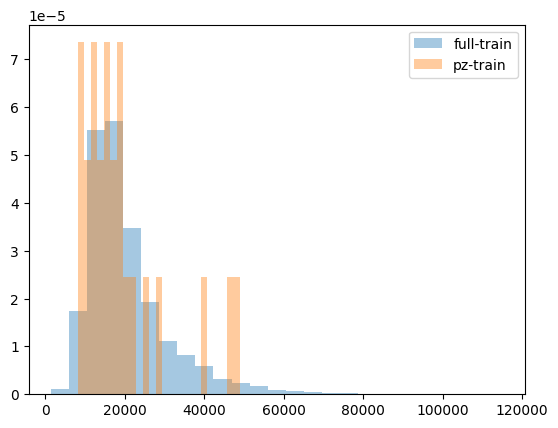

In [686]:
import matplotlib.pyplot as plt

plt.hist(train_text_lengths, density=True, bins=25, alpha=0.4, label='full-train')
plt.hist(val_train_text_lengths, density=True, bins=25, alpha=0.4, label='pz-train')
plt.legend()
plt.show()